In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import sys
#from sklearn import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score


cudnn.benchmark = True
plt.ion()   # interactive mode

C:\Users\Neelam.S\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\Neelam.S\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.trans

In [2]:
from dataset import ELPVImageDataset
from torch.utils.data import random_split, DataLoader

"""
To prepare the data to training, we split the original dataset of 2624 images into two sets, one for training and one for testing
The ratio of training samples to testing samples here is 70% training, 15% validation, 15% testing
"""

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': v2.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

        v2.RandomAffine(degrees=(-3, 3), translate=(0, 0.02), scale=(1.0, 1.02)),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),

    ]),
    'val': v2.Compose([
        v2.Resize(size=(224, 224)),
        transforms.ToTensor(),
    ]),
}

fullDataset = ELPVImageDataset('./labels.csv', 'elpv', transform=data_transforms['train'])

seed = torch.Generator().manual_seed(42)
trainData, valData, testData = random_split(fullDataset, [0.70, 0.15, 0.15], generator=seed)

trainDataloader = DataLoader(trainData, batch_size=16, shuffle=True)
valDataLoader = DataLoader(valData, batch_size=16, shuffle=True)
testDataloader = DataLoader(testData, batch_size=16, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Train Data: {len(trainData)} samples")
print(f"Validation Data: {len(valData)} samples")
print(f"Test Data: {len(testData)} samples")


Train Data: 1837 samples
Validation Data: 394 samples
Test Data: 393 samples


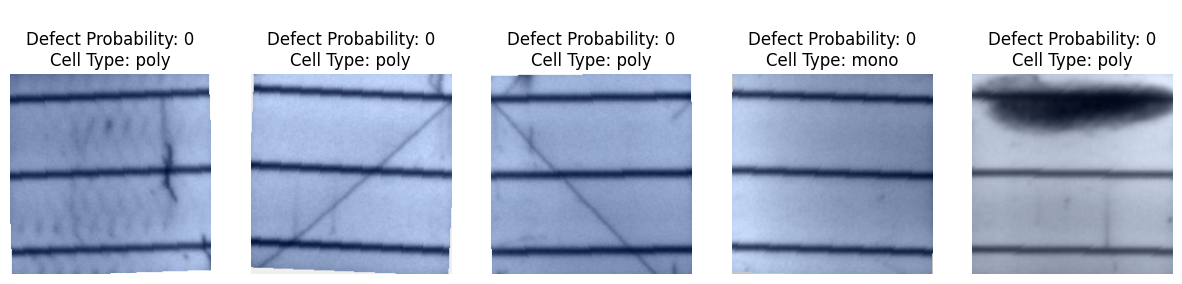

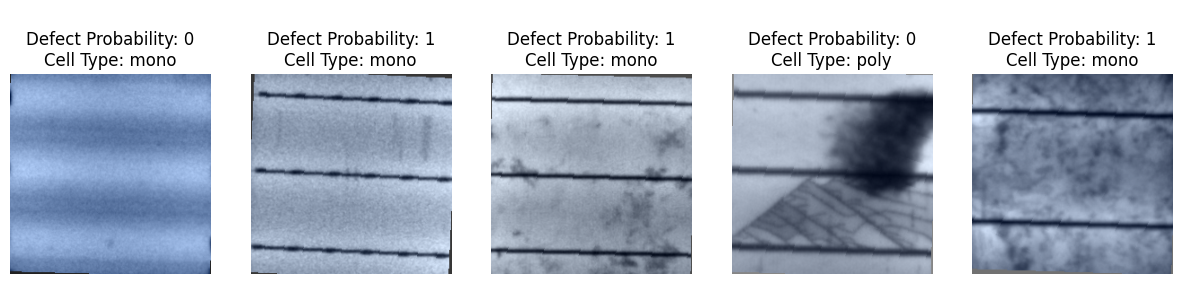

In [3]:

import matplotlib.pyplot as plt

"""
Select a few images to visualize the dataset images, as well as the transforms
"""

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        # Get image, label, cell type
        image, label, cellType = dataset[i]
        cellType = "mono" if cellType == 0 else "poly"

        # Convert image tensor to numpy array for display
        image_np = image.numpy().transpose((1, 2, 0))
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

        # Display the image
        axes[i].imshow(image_np)
        axes[i].axis('off')
        axes[i].set_title(f'\nDefect Probability: {label}\nCell Type: {cellType}')

    plt.show()

show_images(fullDataset) 
show_images(trainData) 

In [4]:
import torch
import torch.nn as nn

"""
Setup our model, criterion, and parameters
Currently using a modified pre-trained resnet18 to take advantage of transfer learning
"""

def closest_probability_class(value):
    probabilities = np.array([0, 1/3, 2/3, 1])
    return min(probabilities, key=lambda x: abs(x - value))

        
class ModifiedResNet(nn.Module):
    """
    This is a modified resnet model in which the final fully connected layer is modified to output
    a single scalar value (the predicted probability of defect).

    In addition, the features going into the final fully connected layer is modified. Namely, we concatenate
    the solar cell type (0 for 'mono', 1 for 'poly') to the feature vector going into the fc player.
    """
    def __init__(self, resnetModel):
        super(ModifiedResNet, self).__init__()
        # Everything except the last linear layer
        self.features = nn.Sequential(*list(resnetModel.children())[:-1])
        
        # Get the number of features going into the last fc layer
        num_ftrs = resnetModel.fc.in_features

        # Redefine the last linear layer / fully connected layer
        # Since we are doing regression, the final output is a scalar value
        self.fc = nn.Linear(num_ftrs + 1, 1)

    def forward(self, image, cellType):
        """
        In addition to the original features being passed into the fully connected layer,
        we also concatenate the solar panel cell type (0 for mono, 1 for poly) to the feature vector
        
        image: 
            The torch tensor image
        
        cellType:
            0 dimensional tensor, where the value is 0 for mono, 1 for poly
        """

        x = self.features(image)
        x = torch.flatten(x, 1)
        

        # Concatenate the additional features
        x = torch.cat((x, cellType), dim=1)

        # Pass through the modified fully connected layer
        x = self.fc(x)
        
        # Round the predicted probability output to the nearest probability class (0, 0.33, 0.66, 1)
        # x = x.apply_(closest_probability_class)

        return x.double()

model_ft = ModifiedResNet(models.resnet18(weights='IMAGENET1K_V1'))
model_ft = model_ft.to(device)

# Since we're doing regression instead of classification, we use MSE instead of Cross Entropy
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
def train_model(model, dataset_sizes, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            
            for images, cell_types, probabilities in dataloaders[phase]:
                # cell_types is of shape [N], where N is the batch size
                # we need to convert this to shape [N, 1] in order to make it easier to 
                # concatenate the cell_type with the feature vector in the resnet model
                cell_types = cell_types.unsqueeze(1)

                # move all data to training device
                images = images.to(device)
                cell_types = cell_types.to(device)
                probabilities = probabilities.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    prediction = model(images, cell_types)
                    prediction = prediction.squeeze() # make sure output tensor is same shape as labels

                    # output = closest_probability_class(prediction)

                    loss = criterion(prediction, probabilities)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * images.size(dim=0) # TODO: do I need this images.size()?
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f}')
    
    return model


In [6]:
"""
Train our model
"""

dataloaders = {
    'train': trainDataloader,
    'val': valDataLoader,
    'test': testDataloader,
}

image_datasets = {
    'train': trainData,
    'val': valData,
    'test': testData,
}

dataset_sizes = {
    'train': len(trainData),
    'val': len(valData),
    'test': len(testData),
}

model_ft = train_model(
    model_ft,
    dataset_sizes,
    dataloaders,
    criterion=nn.MSELoss(),
    optimizer=optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9),
    scheduler=lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1),
    num_epochs=1,
)

Epoch 1/1
----------


C:\Users\Neelam.S\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.2130
val Loss: 0.2080


In [7]:
#Add matrices
#confustion_matrix(model_ft)
model_ft.eval()

ModifiedResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [8]:
#def get_all_preds(model, loader):

# model_ft.eval() # set model to evaluate mode

# print(trainDataloader)


# for phase in ['train', 'val']:
#     if phase == 'val':
#         model_ft.eval()

            # running_loss = 0.0
            
# for images, cell_types, probabilities in dataloaders['val']:
#     cell_types = cell_types.unsqueeze(1)
#     images = images.to(device)
#     cell_types = cell_types.to(device)
#     probabilities = probabilities.to(device)

#     #preds = model_ft(images,cell_types)
#     #print(preds.shape)
#     # print(images.shape)
#     # print(cell_types.shape)
    
#     # T1 = torch.Tensor([1,2,3,4])
#     # T2 = torch.Tensor([0,3,4,1])
#     # d = torch.cat((T1,T2))
#     sup = torch.cat((images,cell_types))
# print(sup.shape)
    #all_preds = torch.cat((all_preds, preds), dim=2)

for images, cell_types, probabilities in dataloaders['val']:
                # cell_types is of shape [N], where N is the batch size
                # we need to convert this to shape [N, 1] in order to make it easier to 
                # concatenate the cell_type with the feature vector in the resnet model
    cell_types = cell_types.unsqueeze(1)

    # move all data to training device
    images = images.to(device)
    cell_types = cell_types.to(device)
    probabilities = probabilities.to(device)

    #optimizer.zero_grad()

    with torch.no_grad():
        prediction = model_ft(images, cell_types)
        prediction1 = prediction.squeeze() # make sure output tensor is same shape as labels

image_np1 = prediction.numpy() #.transpose((1, 2, 0))
#image_np1 = (image_np1 - image_np1.min()) / (image_np1.max() - image_np1.min())
#image_np1 = image_np1.reshape(10*1000,1)
print(image_np1.shape)

#Reference: https://stackoverflow.com/questions/35751306/python-how-to-pad-numpy-array-with-zeros 

new_matrix = np.zeros((224*224*3, 1))
new_matrix[:image_np1.shape[0],:image_np1.shape[1]] = image_np1
print(new_matrix.shape)


# p = tensor([])
# o = tensor.cat((p,prediction1),dim=1)
# print(o)


# train_data = [data for data, _ in trainData]
# print("true vals", train_data)

for i in range(5):
    # Get image, label, cell type
    image, label, cellType = trainData[i]
    cellType = "mono" if cellType == 0 else "poly"

    # Convert image tensor to numpy array for display
    image_np = image.numpy().transpose((1, 2, 0))
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    image = image.unsqueeze(1)

image_np = image_np.reshape(224*224*3, 1)
print(image_np.shape)

#new_test = model_ft.predict()
#confusion_matrix(new_matrix,image_np)

#Reference: https://datascience.stackexchange.com/questions/46019/continuous-variable-not-supported-in-confusion-matrix 

cutoff = 0.66                              
new_matrix_classes = np.zeros_like(new_matrix)    
new_matrix_classes[new_matrix > cutoff] = 1       

image_np_classes = np.zeros_like(new_matrix)
image_np_classes[image_np > cutoff] = 1

confusion_matrix(image_np_classes, new_matrix_classes)

(10, 1)
(150528, 1)
(150528, 1)


array([[134245,      2],
       [ 16281,      0]], dtype=int64)

In [9]:
accuracy_score(image_np_classes, new_matrix_classes)

0.8918274340986394